# Digit Recognizer Data Analysis

**import libraries**

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
import tensorflow as tf
import tensorflow.keras as keras

tf.__version__

'2.1.0'

**load csv raw dataset**

In [2]:
raw_train = pd.read_csv('./data/train.csv', encoding='utf-8')
raw_test = pd.read_csv('./data/test.csv', encoding='utf-8')

# Exploring Dataset

### 1. shape of data

**Train Dataset**  
(42000, 785)
    
**Test Dataset**  
(28000, 784)

In [3]:
raw_train.shape

(42000, 785)

In [4]:
raw_test.shape

(28000, 784)

### 2. Columns of dataset

* Train Dataset and Test Dataset all has pixels of image
* Train Dataset and label for each image

In [5]:
raw_train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [6]:
raw_test.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

## Modeling

### load data and pre processing

In [7]:
def data_augmentation(x_train, y_train):
    aug_x_train = list()
    aug_y_train = list()
    
    for x, y in zip(x_train, y_train):
        aug_x_train.append(x)
        aug_y_train.append(y)
    
        cval = np.median(x)
    
        for _ in range(2):        
            angle = np.random.randint(-15, 15, 1)
            rot_x = ndimage.rotate(x, angle[0], reshape=False, cval=cval)

            shift = np.random.randint(-2, 2, 2)
            shift_x = ndimage.shift(rot_x, shift, cval=cval)
            
            aug_x_train.append(shift_x)
            aug_y_train.append(y)

    aug_x_train = np.array(aug_x_train)
    aug_y_train = np.array(aug_y_train)
            
    return aug_x_train, aug_y_train

In [8]:
def load_digit():
    train = pd.read_csv('./data/train.csv', encoding='utf-8')
    test = pd.read_csv('./data/test.csv', encoding='utf-8')
    
    x_original = train.loc[:, 'pixel0':]
    y_original = train.loc[:, 'label']
    x_test = test.loc[:, 'pixel0':]
    
    x_original = np.array(x_original)
    y_original = np.array(y_original)
    x_test = np.array(x_test)

    x_original = np.reshape(x_original, (-1, 28, 28))
    x_test = np.reshape(x_test, (-1, 28, 28))

    x_train, y_train = data_augmentation(x_original, y_original)
    x_val, y_val = x_original, y_original
        
    x_train = x_train / 255.0
    x_val = x_val / 255.0
    x_test = x_test / 255.0
    
    x_train = np.expand_dims(x_train, -1)
    x_val = np.expand_dims(x_val, -1)
    x_test = np.expand_dims(x_test, -1)
    
    y_train = tf.one_hot(y_train, 10)
    y_val = tf.one_hot(y_val, 10)

    return (x_train, y_train), (x_val, y_val), (x_test)

In [9]:
(x_train, y_train), (x_val, y_val), (x_test) = load_digit()
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)

(126000, 28, 28, 1)
(126000, 10)
(42000, 28, 28, 1)
(42000, 10)
(28000, 28, 28, 1)


***Print Sample Data Augmented***


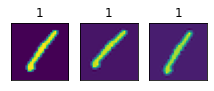

In [11]:
print('***Print Sample Data Augmented***')

for idx in range(1, 4):
    plt.subplot(1, 5, idx)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(y_train[idx-1])))
    plt.imshow(np.reshape(x_train[idx-1], (28, 28)))

plt.show()

### make model

In [12]:
class BNConv(keras.Model):
    def __init__(self, filters, kernel_size, strides=1, padding='same'):
        super(BNConv, self).__init__()
        
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer='glorot_normal')
        self.bn = keras.layers.BatchNormalization()
        self.relu = keras.layers.Activation(keras.activations.relu)
        
    def call(self, x, trainig=False):
        layer = self.conv(x)
        layer = self.bn(layer)
        layer = self.relu(layer)
        
        return layer

In [13]:
class BNDense(keras.Model):
    def __init__(self, units):
        super(BNDense, self).__init__()
        
        self.dense = keras.layers.Dense(units=units, kernel_initializer='glorot_normal')
        self.bn = keras.layers.BatchNormalization()
        self.relu = keras.layers.Activation(keras.activations.relu)
        
    def call(self, x, trainig=False):
        layer = self.dense(x)
        layer = self.bn(layer)
        layer = self.relu(layer)
        
        return layer

In [14]:
class DigitModel(keras.Model):
    def __init__(self):
        super(DigitModel, self).__init__()
        
        self.conv1 = BNConv(filters=16, kernel_size=(3, 3), padding='same')
        self.pool1 = keras.layers.MaxPool2D(padding='same')

        self.conv2 = BNConv(filters=32, kernel_size=(3, 3), padding='same')
        self.pool2 = keras.layers.MaxPool2D(padding='same')
        
        self.conv3 = BNConv(filters=64, kernel_size=(3, 3), padding='same')
        self.pool3 = keras.layers.MaxPool2D(padding='same')
        self.flat3 = keras.layers.Flatten()
        
        self.dense4 = BNDense(units=128)
        self.dropout4 = keras.layers.Dropout(rate=0.5)
        
        self.dense5 = keras.layers.Dense(units=10)
        
    def call(self, x, training=False):
        layer1 = self.conv1(x, training=training)
        layer1 = self.pool1(layer1)
        
        layer2 = self.conv2(layer1, training=training)
        layer2 = self.pool2(layer2)
        
        layer3 = self.conv3(layer2, training=training)
        layer3 = self.pool3(layer3)
        layer3 = self.flat3(layer3)
        
        layer4 = self.dense4(layer3, training=training)
        layer4 = self.dropout4(layer4)
        
        y = self.dense5(layer4)
        
        return y

In [15]:
num_models = 5
models = list()
for _ in range(num_models):
    models.append(DigitModel())

In [16]:
temp = keras.Input(shape=x_val.shape[1:])
models[0](temp)
models[0].summary()

Model: "digit_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn_conv (BNConv)             (None, 28, 28, 16)        224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
bn_conv_1 (BNConv)           (None, 14, 14, 32)        4768      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
bn_conv_2 (BNConv)           (None, 7, 7, 64)          18752     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              

### performance evaulation functions

In [17]:
def loss_fn(model, x, y, training=True):
    logits = model(x, training=training)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    return loss

In [18]:
def predict(models, x, y, training=False):
    prediction = np.zeros_like(y)
    for model in models:
        prediction += model(x, training=training)
    return prediction

In [19]:
def accuracy_fn(model, x, y, training=False):
    prediction = predict(model, x, y, training=training)
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    return accuracy

### hyper parameters

In [20]:
learning_rate = 0.001
batch_size = 128
epochs = 100
iterations = len(x_train) // batch_size

### checkpoint and summary

In [21]:
def load_checkpoint(model, checkpoint_dir):
    print('[*] find checkpoint at {}'.format(checkpoint_dir))
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    
    if ckpt:
        latest_checkpoint_name = os.path.basename(ckpt.model_checkpoint_path)
        checkpoint = tf.train.Checkpoint(dnn=model)
        checkpoint.restore(os.path.join(checkpoint_dir, latest_checkpoint_name))
        
        counter = int(latest_checkpoint_name.split('-')[1])
        print('[*] checkpoint {} restored'.format(latest_checkpoint_name))
        return True, counter
    else:
        print('[*] checkpoint not found')
        return False, 0

In [22]:
current_dir = os.getcwd()
checkpoint_dir_base = 'checkpoints'
model_dir = 'cnn'
log_dir = 'logs'

checkpoint_dirs = list()
checkpoint_prefixes = list()
checkpoints = list()

for idx, model in enumerate(models):
    ensemble_dir = 'ensemble_{}'.format(idx)
    checkpoint_dir = os.path.join(current_dir, checkpoint_dir_base, model_dir, ensemble_dir)
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_dirs.append(checkpoint_dir)
    
    checkpoints.append(tf.train.Checkpoint(dnn=model))
    
    checkpoint_prefix = os.path.join(checkpoint_dir, model_dir)
    checkpoint_prefixes.append(checkpoint_prefix)

In [23]:
log_dir = os.path.join(current_dir, log_dir, model_dir)
summary_writer = tf.summary.create_file_writer(log_dir)

### optimizer

In [24]:
lr_decay = keras.optimizers.schedules.ExponentialDecay(learning_rate, 10, 0.95, staircase=True)
optimizer = keras.optimizers.Adam(learning_rate=lr_decay)

### data pipelining

In [25]:
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.shuffle(150000)
dataset_train = dataset_train.prefetch(150000)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.repeat()

dataset_train_iterator = iter(dataset_train)

In [26]:
dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataset_val = dataset_val.prefetch(50000)
dataset_val = dataset_val.batch(len(x_val))
dataset_val = dataset_val.repeat()

dataset_val_iterator = iter(dataset_val)

### load checkpoint

In [27]:
for model, checkpoint_dir in zip(models, checkpoint_dirs):
    could_load, checkpoint_counter = load_checkpoint(model, checkpoint_dir)

if could_load:
    start_epoch = checkpoint_counter // iterations
    start_iteration = checkpoint_counter % iterations
    counter = checkpoint_counter
else:
    start_epoch = 0
    start_iteration = 0
    counter = checkpoint_counter

[*] find checkpoint at /Users/dhsong/Workspaces/Practices/Kaggle Data Analysis/Digit Recognizer/checkpoints/cnn/ensemble_0
[*] checkpoint cnn-5905-121 restored
[*] find checkpoint at /Users/dhsong/Workspaces/Practices/Kaggle Data Analysis/Digit Recognizer/checkpoints/cnn/ensemble_1
[*] checkpoint cnn-5905-121 restored
[*] find checkpoint at /Users/dhsong/Workspaces/Practices/Kaggle Data Analysis/Digit Recognizer/checkpoints/cnn/ensemble_2
[*] checkpoint cnn-5905-121 restored
[*] find checkpoint at /Users/dhsong/Workspaces/Practices/Kaggle Data Analysis/Digit Recognizer/checkpoints/cnn/ensemble_3
[*] checkpoint cnn-5905-121 restored
[*] find checkpoint at /Users/dhsong/Workspaces/Practices/Kaggle Data Analysis/Digit Recognizer/checkpoints/cnn/ensemble_4
[*] checkpoint cnn-5905-121 restored


### training

In [27]:
with summary_writer.as_default():
    for epoch in range(start_epoch, epochs):
        start_time = time.time()

        train_loss = 0.
        train_acc = 0.

        for iteration in range(start_iteration, iterations):
            train_features, train_labels = dataset_train_iterator.get_next()

            batch_loss = 0.
            batch_acc = 0.

            for model in models:
                with tf.GradientTape() as tape:
                    loss = loss_fn(model, train_features, train_labels, True)
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

                batch_loss += loss

            batch_loss /= num_models
            batch_acc = accuracy_fn(models, train_features, train_labels, False)

            train_loss += batch_loss
            train_acc += batch_acc

            counter += 1

            tf.summary.scalar('batch_loss', batch_loss, step=counter)
            tf.summary.scalar('batch_acc', batch_acc, step=counter)


            if iteration % 10 == 0:
                print('Epoch {:4d} Iteration [{:4d}/{:4d}] Batch loss={:7.4f} acc={:.2%}'.format(epoch + 1, iteration + 1, iterations, batch_loss, batch_acc))

            if iteration % 50 == 0:
                for checkpoint, checkpoint_prefix in zip(checkpoints, checkpoint_prefixes):
                    checkpoint.save(file_prefix=checkpoint_prefix + '-{}'.format(counter))

        train_loss /= iterations
        train_acc /= iterations

        val_features, val_labels = dataset_val_iterator.get_next()
        val_loss = 0.
        for model in models:
            val_loss += loss_fn(model, val_features, val_labels, False)
        val_loss /= num_models
        val_acc = accuracy_fn(models, val_features, val_labels, False)
        
        tf.summary.scalar('train_loss', train_loss, step=counter)
        tf.summary.scalar('train_acc', train_acc, step=counter)
        tf.summary.scalar('val_loss', val_loss, step=counter)
        tf.summary.scalar('val_acc', val_acc, step=counter)

        print('*** {:8.4f} Epoch {:4d} [T] loss={:7.4f} acc={:.2%}\t[v] loss={:7.4f} acc={:.2%}\t***\n'.format(time.time() - start_time, epoch + 1, train_loss, train_acc, val_loss, val_acc))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

Epoch    1 Iteration [ 741/ 984] Batch loss= 0.2719 acc=96.88%
Epoch    1 Iteration [ 751/ 984] Batch loss= 0.2612 acc=97.66%
Epoch    1 Iteration [ 761/ 984] Batch loss= 0.2590 acc=97.66%
Epoch    1 Iteration [ 771/ 984] Batch loss= 0.3525 acc=92.97%
Epoch    1 Iteration [ 781/ 984] Batch loss= 0.3269 acc=96.09%
Epoch    1 Iteration [ 791/ 984] Batch loss= 0.3476 acc=96.09%
Epoch    1 Iteration [ 801/ 984] Batch loss= 0.2927 acc=96.09%
Epoch    1 Iteration [ 811/ 984] Batch loss= 0.2714 acc=96.88%
Epoch    1 Iteration [ 821/ 984] Batch loss= 0.2904 acc=93.75%
Epoch    1 Iteration [ 831/ 984] Batch loss= 0.2378 acc=96.88%
Epoch    1 Iteration [ 841/ 984] Batch loss= 0.2569 acc=98.44%
Epoch    1 Iteration [ 851/ 984] Batch loss= 0.3194 acc=95.31%
Epoch    1 Iteration [ 861/ 984] Batch loss= 0.2458 acc=95.31%
Epoch    1 Iteration [ 871/ 984] Batch loss= 0.4290 acc=92.19%
Epoch    1 Iteration [ 881/ 984] Batch loss= 0.3124 acc=95.31%
Epoch    1 Iteration [ 891/ 984] Batch loss= 0.2127 acc

Epoch    3 Iteration [  41/ 984] Batch loss= 0.2608 acc=97.66%
Epoch    3 Iteration [  51/ 984] Batch loss= 0.2587 acc=97.66%
Epoch    3 Iteration [  61/ 984] Batch loss= 0.3353 acc=95.31%
Epoch    3 Iteration [  71/ 984] Batch loss= 0.3478 acc=92.97%
Epoch    3 Iteration [  81/ 984] Batch loss= 0.2517 acc=97.66%
Epoch    3 Iteration [  91/ 984] Batch loss= 0.2655 acc=94.53%
Epoch    3 Iteration [ 101/ 984] Batch loss= 0.3292 acc=96.09%
Epoch    3 Iteration [ 111/ 984] Batch loss= 0.3240 acc=96.88%
Epoch    3 Iteration [ 121/ 984] Batch loss= 0.3211 acc=95.31%
Epoch    3 Iteration [ 131/ 984] Batch loss= 0.3027 acc=96.09%
Epoch    3 Iteration [ 141/ 984] Batch loss= 0.4478 acc=92.19%
Epoch    3 Iteration [ 151/ 984] Batch loss= 0.2918 acc=97.66%
Epoch    3 Iteration [ 161/ 984] Batch loss= 0.4023 acc=92.97%
Epoch    3 Iteration [ 171/ 984] Batch loss= 0.3368 acc=93.75%
Epoch    3 Iteration [ 181/ 984] Batch loss= 0.3301 acc=95.31%
Epoch    3 Iteration [ 191/ 984] Batch loss= 0.2622 acc

Epoch    4 Iteration [ 341/ 984] Batch loss= 0.3173 acc=95.31%
Epoch    4 Iteration [ 351/ 984] Batch loss= 0.3455 acc=92.97%
Epoch    4 Iteration [ 361/ 984] Batch loss= 0.3191 acc=94.53%
Epoch    4 Iteration [ 371/ 984] Batch loss= 0.2532 acc=97.66%
Epoch    4 Iteration [ 381/ 984] Batch loss= 0.2954 acc=95.31%
Epoch    4 Iteration [ 391/ 984] Batch loss= 0.2986 acc=94.53%
Epoch    4 Iteration [ 401/ 984] Batch loss= 0.2502 acc=95.31%
Epoch    4 Iteration [ 411/ 984] Batch loss= 0.2960 acc=94.53%
Epoch    4 Iteration [ 421/ 984] Batch loss= 0.2544 acc=98.44%
Epoch    4 Iteration [ 431/ 984] Batch loss= 0.2545 acc=96.09%
Epoch    4 Iteration [ 441/ 984] Batch loss= 0.3048 acc=95.31%
Epoch    4 Iteration [ 451/ 984] Batch loss= 0.3071 acc=95.31%
Epoch    4 Iteration [ 461/ 984] Batch loss= 0.2571 acc=96.88%
Epoch    4 Iteration [ 471/ 984] Batch loss= 0.3462 acc=96.88%
Epoch    4 Iteration [ 481/ 984] Batch loss= 0.2839 acc=96.09%
Epoch    4 Iteration [ 491/ 984] Batch loss= 0.3559 acc

Epoch    5 Iteration [ 641/ 984] Batch loss= 0.3268 acc=94.53%
Epoch    5 Iteration [ 651/ 984] Batch loss= 0.2564 acc=97.66%
Epoch    5 Iteration [ 661/ 984] Batch loss= 0.2770 acc=95.31%
Epoch    5 Iteration [ 671/ 984] Batch loss= 0.2359 acc=98.44%
Epoch    5 Iteration [ 681/ 984] Batch loss= 0.3487 acc=93.75%
Epoch    5 Iteration [ 691/ 984] Batch loss= 0.2595 acc=96.88%
Epoch    5 Iteration [ 701/ 984] Batch loss= 0.3251 acc=93.75%
Epoch    5 Iteration [ 711/ 984] Batch loss= 0.3138 acc=96.88%
Epoch    5 Iteration [ 721/ 984] Batch loss= 0.3154 acc=95.31%
Epoch    5 Iteration [ 731/ 984] Batch loss= 0.3232 acc=94.53%
Epoch    5 Iteration [ 741/ 984] Batch loss= 0.2160 acc=99.22%
Epoch    5 Iteration [ 751/ 984] Batch loss= 0.2866 acc=96.09%
Epoch    5 Iteration [ 761/ 984] Batch loss= 0.2606 acc=97.66%
Epoch    5 Iteration [ 771/ 984] Batch loss= 0.2267 acc=96.88%
Epoch    5 Iteration [ 781/ 984] Batch loss= 0.2871 acc=96.88%
Epoch    5 Iteration [ 791/ 984] Batch loss= 0.3712 acc

Epoch    6 Iteration [ 941/ 984] Batch loss= 0.3468 acc=92.97%
Epoch    6 Iteration [ 951/ 984] Batch loss= 0.3038 acc=96.09%
Epoch    6 Iteration [ 961/ 984] Batch loss= 0.2692 acc=94.53%
Epoch    6 Iteration [ 971/ 984] Batch loss= 0.2961 acc=92.97%
Epoch    6 Iteration [ 981/ 984] Batch loss= 0.3066 acc=95.31%
*** 507.0139 Epoch    6 [T] loss= 0.2999 acc=95.71%	[v] loss= 0.1445 acc=97.14%	***

Epoch    7 Iteration [   1/ 984] Batch loss= 0.2482 acc=97.66%
Epoch    7 Iteration [  11/ 984] Batch loss= 0.3311 acc=95.31%
Epoch    7 Iteration [  21/ 984] Batch loss= 0.3316 acc=95.31%
Epoch    7 Iteration [  31/ 984] Batch loss= 0.4167 acc=91.41%
Epoch    7 Iteration [  41/ 984] Batch loss= 0.2650 acc=96.88%


KeyboardInterrupt: 

### Evaluation

In [28]:
features, labels = dataset_val_iterator.get_next()
loss = 0.
for model in models:
    loss += loss_fn(model, features, labels, False)
loss /= num_models

acc = accuracy_fn(models, features, labels, False)

print('loss = {:7.4f} acc = {:.2%}'.format(loss, acc))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

### submission

In [36]:
results = np.zeros((x_test.shape[0], 10))
for model in models:
    results += model(x_test).numpy()
labels = np.argmax(results, axis=-1)

submission = submission = pd.concat([pd.Series(range(1, x_test.shape[0] + 1)), pd.Series(labels)], axis=1)
submission.columns = ['ImageId', 'Label']
submission.to_csv('./data/submission/submission.csv', index=False, encoding='utf-8')